In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [6]:
data=pd.read_excel("C:\ML&AI\TextClassification\RAW DATA(Main Update)#2 (2019-07-02).xlsx", sheet_name="All",skiprows=5)
data.columns.tolist()

#countries_english=['RLTD','RAME','RIND','RPAC','RSAF','RKOR']

filtered_data = data[(data["Filtering\n(Credit/Age/Class)"]=="No") & (data["Work Type"]=="Visit") & (data["Case Type (Related Case)"]=="Complaint") & (data["Country"].str.contains("RLTD|RAME|RIND|RPAC|RSAF|RKOR"))]
                 
filtered_data.drop_duplicates(subset="SWO Number")

#reset all indexes as we dropped rows above
filtered_data = filtered_data.reset_index(drop=True)

#concatenate 3 columns of text
filtered_data['Text']= filtered_data['Case Description'] +' ' + filtered_data['Investigation'] + ' ' + filtered_data['Corrective Action']

# final columns for classification
dataframe=filtered_data.loc[:,['SWO Number','Text','RMED FaultCode L1(New)']]
#,'RMED FaultCode L2(New)', 'RMED FaultCode L3(New)', 'RMED FaultCode L4(New)',]

#If the count of target is less than 5%, combine to others type
classif = dataframe['RMED FaultCode L1(New)'].value_counts(normalize=True)
idx = classif[classif.lt(0.05)].index
dataframe.loc[dataframe['RMED FaultCode L1(New)'].isin(idx),'RMED FaultCode L1(New)'] = 'Others'

#prediction data -  save the rows where tgt is blank from dataframe
pred_X_Y = dataframe.loc[dataframe['RMED FaultCode L1(New)'].isnull(), ['SWO Number','Text','RMED FaultCode L1(New)']]

#get data after filtering where target is blank and text is blank
dataframe = dataframe.loc[dataframe['RMED FaultCode L1(New)'].notnull(), ['SWO Number','Text','RMED FaultCode L1(New)']]
dataframe = dataframe.loc[dataframe['Text'].notnull(), ['SWO Number','Text','RMED FaultCode L1(New)']]
dataframe = dataframe.reset_index(drop=True)

dataframe['Prediction'].value_counts()

KeyError: 'Prediction'

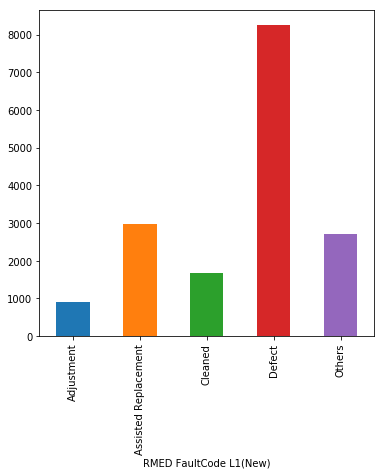

In [3]:
fig = plt.figure(figsize=(6,6))
dataframe.groupby('RMED FaultCode L1(New)').Text.count().plot.bar(ylim=0)
plt.show()

In [ ]:
from sklearn.utils import resample

######################   down sampling of majority class dint help in improving accuracy  ####################
df_majority = dataframe[dataframe['RMED FaultCode L1(New)']=='Defect']
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=300,     # to match minority class
                                 random_state=123) # reproducible results

dataframe = dataframe[dataframe['RMED FaultCode L1(New)']!='Defect']
dataframe = pd.concat([dataframe,df_majority_downsampled])

In [ ]:
fig = plt.figure(figsize=(6,6))
dataframe.groupby('RMED FaultCode L1(New)').Text.count().plot.bar(ylim=0)
plt.show()

In [4]:
dataframe['category_id'] = dataframe['RMED FaultCode L1(New)'].factorize()[0]
category_id_dataframe = dataframe[['RMED FaultCode L1(New)', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_dataframe.values)
id_to_category = dict(category_id_dataframe[['category_id', 'RMED FaultCode L1(New)']].values)
dataframe.head()

#https://bbengfort.github.io/tutorials/2016/05/19/text-classification-nltk-sckit-learn.html
#The difference is that stem might not be an actual word whereas, lemma is an actual language word. 
#in lemma, you used WordNet corpus & corpus for stop words to produce lemma which makes it slower than stemming.
import re
from nltk.stem.porter import PorterStemmer
porter_stemmer = PorterStemmer()

def stemming_tokenizer(str_input):
    words = re.sub(r"[^A-Za-z0-9\-]", " ", str_input).lower().split()
    words = [porter_stemmer.stem(word) for word in words]
    return words

from sklearn.feature_extraction.text import TfidfVectorizer
#min_df = When building the vocabulary ignore terms that have a document frequency strictly lower than the given threshold.
#norm='l2' = The cosine similarity between two vectors is their dot product when l2 norm has been applied.
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=2, norm='l2', encoding='latin-1', ngram_range=(1, 2),
                        stop_words='english',token_pattern=r'(?u)\b[A-Za-z]+\b', tokenizer=stemming_tokenizer)
features = tfidf.fit_transform(dataframe.Text).toarray()
labels = dataframe.category_id
features.shape

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
  'stop

(4993, 25289)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default so

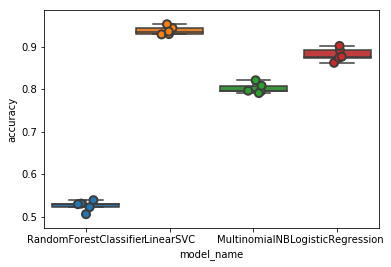

model_name
LinearSVC                 0.938311
LogisticRegression        0.881233
MultinomialNB             0.802324
RandomForestClassifier    0.525123
Name: accuracy, dtype: float64

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])


import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df,size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

cv_df.groupby('model_name').accuracy.mean()

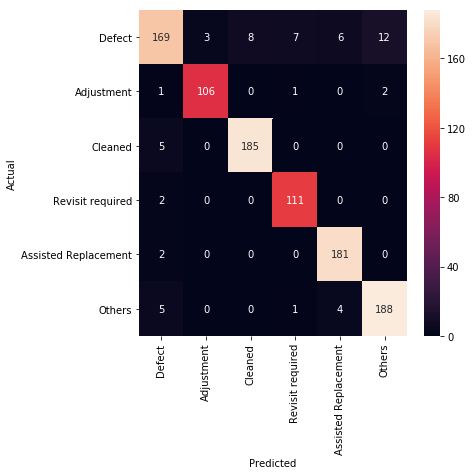

In [7]:
#continue with the best model further 
# may be due to imbalance class - balance it further
# confusion matrix and heat map to see what is predicted incorrectly
# major of the predictions end up on the diagonal (predicted label = actual label)
from sklearn.model_selection import train_test_split
model = LinearSVC()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, dataframe.index, test_size=0.20, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(6,6))
sns.heatmap(conf_mat, annot=True, fmt='d',xticklabels=category_id_dataframe['RMED FaultCode L1(New)'].values, yticklabels=category_id_dataframe['RMED FaultCode L1(New)'].values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [13]:
from IPython.display import display
for predicted in category_id_dataframe.category_id:
  for actual in category_id_dataframe.category_id:
    if predicted != actual and conf_mat[actual, predicted] >= 3:
      print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], id_to_category[predicted], conf_mat[actual, predicted]))
      display(dataframe.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['RMED FaultCode L1(New)', 'Text']])
      print('')

'Cleaned' predicted as 'Defect' : 5 examples.


,RMED FaultCode L1(New),Text
1407,Revisit required,Haval Ozgun 07737 457222 Analyser found to be ...
2116,Revisit required,Keeps asking to change SP and SC\nSidki AKay K...
1786,Revisit required,Rinse error. Check the system. Clean the rinse...
508,Revisit required,Oximetry parameters are failed in calibration....
508,Revisit required,Oximetry parameters are failed in calibration....
508,Revisit required,Oximetry parameters are failed in calibration....
508,Revisit required,Oximetry parameters are failed in calibration....



'Others' predicted as 'Defect' : 5 examples.


,RMED FaultCode L1(New),Text
180,Revisit required,Simon Donnelly Tel 0203 2994446 Bleep 411 Anal...
746,Revisit required,Customer states that the inlet intermittently ...
1030,Revisit required,Hypochlorite Detected in analyzer. Unit givin...
1030,Revisit required,Hypochlorite Detected in analyzer. Unit givin...
1030,Revisit required,Hypochlorite Detected in analyzer. Unit givin...
1030,Revisit required,Hypochlorite Detected in analyzer. Unit givin...
1030,Revisit required,Hypochlorite Detected in analyzer. Unit givin...
1030,Revisit required,Hypochlorite Detected in analyzer. Unit givin...
1030,Revisit required,Hypochlorite Detected in analyzer. Unit givin...
1030,Revisit required,Hypochlorite Detected in analyzer. Unit givin...



'Defect' predicted as 'Adjustment' : 3 examples.


,RMED FaultCode L1(New),Text
1122,Revisit required,Please call Claire Latham on 01553 613 780 Sam...
1893,Revisit required,Thb cals failing Analyser giving low values o...
1503,Revisit required,Setsafe_22 Not Operational and inlet door not ...



'Defect' predicted as 'Cleaned' : 8 examples.


,RMED FaultCode L1(New),Text
348,Revisit required,Process wheel error. Process wheel error. Chec...
2053,Revisit required,"pressure test error, Oxi value error gasket ho..."
723,Revisit required,Storage wheel is failed Remove broken catridge...
79,Revisit required,Sample aborting again and again. Sample aborti...
1679,Revisit required,Crea Failing QC QC Level 1 and 2 are failing f...
854,Revisit required,Leakage in Gaskets Gasket Leakage Chekced the ...
1190,Revisit required,Calibration failed after cal adjustment starte...
2225,Revisit required,Temperature error in sample result Find temper...



'Defect' predicted as 'Revisit required' : 7 examples.


,RMED FaultCode L1(New),Text
1288,Revisit required,"Intermittent, frequent error 791, no Oximetry ..."
2067,Revisit required,HCT measurements errors on patient samples Re...
523,Revisit required,Oxi Parameters Failing on Level 3 of VK Kit Re...
2160,Revisit required,Printing Problem Checked and found that when p...
2229,Revisit required,Service Call. The analyzer is not switching on...
154,Revisit required,Analyzer not Initializing it is showing error ...
1506,Revisit required,Please call Anna 07984 464577 Screen frozen sa...



'Defect' predicted as 'Assisted Replacement' : 6 examples.


,RMED FaultCode L1(New),Text
1181,Revisit required,Ca failing calibrations \nStatus high 21.19 C...
289,Revisit required,TREND FOR PCO2 FOUR LAST SEVERAL MONTHS HAS BE...
1082,Revisit required,Customer states unit having Intermittent Inhom...
449,Revisit required,Leakage at elmetII module. Leakage at Met2 mo...
461,Revisit required,"Leak detected, unable to clear issue Client ad..."
2021,Revisit required,"Error codes 1258, 1259, and 1264. Error codes ..."



'Others' predicted as 'Assisted Replacement' : 4 examples.


,RMED FaultCode L1(New),Text
942,Revisit required,Faye 02075804400 ex 10867\nSilva 02075804400 ...
2045,Revisit required,Na calibration sensitivity is low. Need to rep...
2045,Revisit required,Na calibration sensitivity is low. Need to rep...
252,Revisit required,PO2 is on higher end of WDC report. Checked da...
2045,Revisit required,Na calibration sensitivity is low. Need to rep...
2045,Revisit required,Na calibration sensitivity is low. Need to rep...



'Defect' predicted as 'Others' : 12 examples.


,RMED FaultCode L1(New),Text
1070,Revisit required,Haval Ozgon Tel: 07737 457222 All three Analys...
784,Revisit required,Unable to Edit patient demo graphics Customer ...
960,Revisit required,Analyzer does not read the smart chip on the s...
776,Revisit required,Unable to scan barcodes Continued investigatio...
1169,Revisit required,Anna Morton 01708435000 ext 6672 or ext 2621 T...
1004,Revisit required,Customer call stating analyzer will not automa...
84,Revisit required,Lisa 01865 221596 customer reporting that the ...
1161,Revisit required,Application software error. found application ...
1923,Revisit required,Investigation by biomed Jakeer:\nAnlayser was ...
1284,Revisit required,Claire Bailey Tel: 01708 435000 Analyser front...


In [9]:
model.fit(features, labels)
N = 10
for dataframe['RMED FaultCode L1(New)'], category_id in sorted(category_to_id.items()):
  indices = np.argsort(model.coef_[category_id])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
  bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
#  print("# '{}':".format(dataframe['RMED FaultCode L1(New)']))
  print(category_id)
  print("  . Top unigrams:\n      . {}".format('\n       . '.join(unigrams)))
  print("  . Top bigrams:\n       . {}".format('\n       . '.join(bigrams)))

1
  . Top unigrams:
      . lamp
       . adjust
       . close
       . reset
       . halogen
       . misalign
       . jumper
       . rais
       . icon
       . cthb
  . Top bigrams:
       . inlet wheel
       . blank cal
       . posit adjust
       . halogen lamp
       . printer error
       . probe posit
       . reset jumper
       . stick probe
       . cabl reconnect
       . clean cabl
4
  . Top unigrams:
      . membran
       . sp
       . electrod
       . replac
       . cassett
       . sensit
       . 964
       . cl
       . calibr
       . unstabl
  . Top bigrams:
       . replac solut
       . expir check
       . replac lactat
       . sensor cassett
       . qc fail
       . reagent calibr
       . membran run
       . electrod calibr
       . error 964
       . ph unstabl
2
  . Top unigrams:
      . clean
       . clot
       . flush
       . remov
       . dust
       . decontamin
       . chamber
       . dirti
       . scanner
       . water
  . Top bigram

In [12]:
from sklearn import metrics
#print(metrics.classification_report(y_test, y_pred, target_names=dataframe['RMED FaultCode L1(New)'].unique()))
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
acc2=metrics.accuracy_score(y_test,y_pred)
print(acc2)

0.9409409409409409
